#Регрессия для СC50

50% Cytotoxic Concentration — это концентрация вещества, при которой оно вызывает гибель 50% клеток в клеточной культуре. Этот показатель используется для оценки цитотоксичности (токсичности для клеток) химического соединения или лекарства.

In [34]:
!pip install -q catboost
!pip install -q optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings('ignore')

In [35]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_CC50_mM.csv')

Saving selected_features_CC50_mM.csv to selected_features_CC50_mM (1).csv


In [36]:
df.head()

,Unnamed: 0,MolWt,FpDensityMorgan1,PEOE_VSA7,BCUT2D_CHGLO,VSA_EState4,MinPartialCharge,BalabanJ,MolLogP,TPSA,...,SMR_VSA10,NHOHCount,EState_VSA6,EState_VSA2,SlogP_VSA3,NumHAcceptors,SlogP_VSA1,RingCount,fr_allylic_oxid,"CC50, mM"
0,0,384.652,0.642857,74.032366,-2.343082,4.807589,-0.293526,1.164038,7.1212,24.72,...,11.423370,0,11.42337,0.000000,0.000000,2,0.000000,4,0,175.482382
1,1,388.684,0.607143,97.951860,-2.394690,2.153503,-0.313407,1.080362,6.1556,24.06,...,0.000000,2,0.00000,0.000000,0.000000,2,10.633577,4,0,5.402819
2,2,446.808,0.562500,74.032366,-2.477203,2.184127,-0.325573,1.219066,7.1292,0.00,...,0.000000,0,0.00000,0.000000,0.000000,0,0.000000,4,0,161.142320
3,3,398.679,0.620690,74.032366,-2.342885,4.827852,-0.293526,1.120513,7.5113,24.72,...,11.423370,0,11.42337,0.000000,0.000000,2,0.000000,4,0,107.855654
4,4,466.713,0.600000,103.003916,-2.342009,9.071783,-0.257239,1.136678,9.1148,24.72,...,22.798143,0,0.00000,10.829981,6.420822,2,0.000000,6,0,139.270991


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         998 non-null    int64  
 1   MolWt              998 non-null    float64
 2   FpDensityMorgan1   998 non-null    float64
 3   PEOE_VSA7          998 non-null    float64
 4   BCUT2D_CHGLO       998 non-null    float64
 5   VSA_EState4        998 non-null    float64
 6   MinPartialCharge   998 non-null    float64
 7   BalabanJ           998 non-null    float64
 8   MolLogP            998 non-null    float64
 9   TPSA               998 non-null    float64
 10  PEOE_VSA6          998 non-null    float64
 11  EState_VSA4        998 non-null    float64
 12  BCUT2D_LOGPLOW     998 non-null    float64
 13  FractionCSP3       998 non-null    float64
 14  SMR_VSA7           998 non-null    float64
 15  NumRotatableBonds  998 non-null    int64  
 16  SMR_VSA10          998 non

In [38]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Подготовка и анализ данных

In [39]:
# Вычисляем логарифм от IC50
if 'IC50_mM_log' not in df.columns:
    df['CC50_mM_log'] = -np.log10(df['CC50, mM'])
    print("Логарифмированная целевая переменная добавлена (CC50)")

Логарифмированная целевая переменная добавлена (CC50)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MolWt              998 non-null    float64
 1   FpDensityMorgan1   998 non-null    float64
 2   PEOE_VSA7          998 non-null    float64
 3   BCUT2D_CHGLO       998 non-null    float64
 4   VSA_EState4        998 non-null    float64
 5   MinPartialCharge   998 non-null    float64
 6   BalabanJ           998 non-null    float64
 7   MolLogP            998 non-null    float64
 8   TPSA               998 non-null    float64
 9   PEOE_VSA6          998 non-null    float64
 10  EState_VSA4        998 non-null    float64
 11  BCUT2D_LOGPLOW     998 non-null    float64
 12  FractionCSP3       998 non-null    float64
 13  SMR_VSA7           998 non-null    float64
 14  NumRotatableBonds  998 non-null    int64  
 15  SMR_VSA10          998 non-null    float64
 16  NHOHCount          998 non

In [41]:
# Определяем целевую переменную
TARGET_COL = 'CC50_mM_log'

# Копируем датафрейм
df_clean = df.copy()

# Оригинальный логарифмированный pIC50
original_true = df[TARGET_COL].copy()

In [42]:
# Ограничение выбросов в логарифмированной переменной
def cap_outliers(series, lower_percentile=0.01, upper_percentile=0.99):
    lower_cap = series.quantile(lower_percentile)
    upper_cap = series.quantile(upper_percentile)
    return np.clip(series, lower_cap, upper_cap)

df_clean[TARGET_COL] = cap_outliers(df_clean[TARGET_COL])
print("Выбросы в СC50 ограничены")

Выбросы в СC50 ограничены


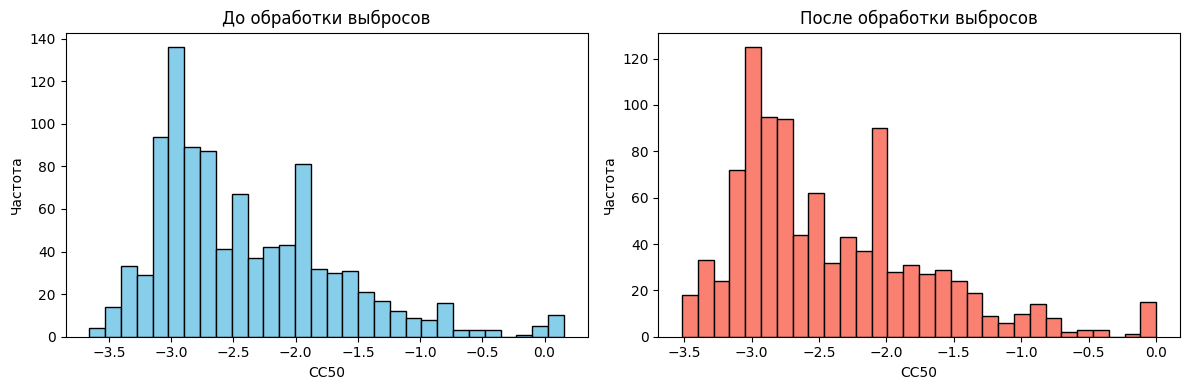

In [43]:
# Оригинальное и обработанное значение
original = original = original_true.copy()
capped = df_clean[TARGET_COL]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(original, bins=30, color='skyblue', edgecolor='black')
plt.title('До обработки выбросов')
plt.xlabel('СC50')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(capped, bins=30, color='salmon', edgecolor='black')
plt.title('После обработки выбросов')
plt.xlabel('СC50')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


"Хвосты" жёстко обрезаны — отсекаем верхние и нижние 1% значений по распределению.
Это снижает влияние экстремальных выбросов, особенно актуально для деревьев, бустинга и CatBoost, которые менее чувствительны к распределению целевой переменной.

Линейные модели более чувствительны к асимметрии и выбросам

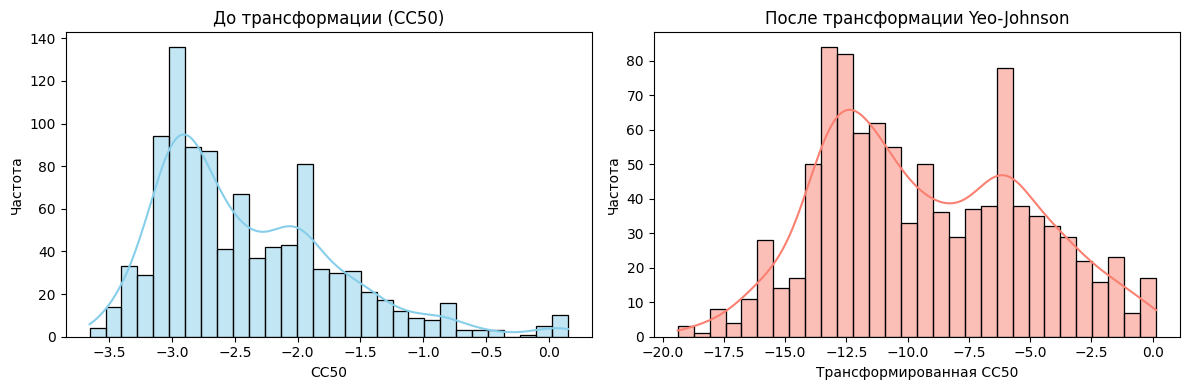

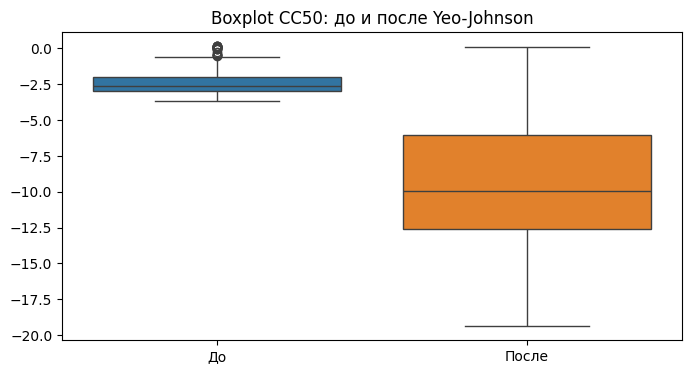

In [44]:
# Оригинальная логарифмированная целевая переменная
original = original_true.copy()

# Применяем Yeo-Johnson только для анализа
pt = PowerTransformer(method='yeo-johnson', standardize=False)
transformed = pt.fit_transform(original.values.reshape(-1, 1)).flatten()

# Визуализация распределений
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(original, bins=30, kde=True, color='skyblue')
plt.title("До трансформации (СC50)")
plt.xlabel("СC50")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(transformed, bins=30, kde=True, color='salmon')
plt.title("После трансформации Yeo-Johnson")
plt.xlabel("Трансформированная СC50")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Дополнительно: boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(data=[original, transformed])
plt.xticks([0, 1], ['До', 'После'])
plt.title('Boxplot СC50: до и после Yeo-Johnson')
plt.show()

делаем предобработку исхъодного датасета

In [45]:
# Выделяем числовые признаки (кроме целевых)
feature_cols = [col for col in df_clean.columns if col not in ['CC50, mM', 'CC50_mM_log']]

In [46]:
print(feature_cols)

['MolWt', 'FpDensityMorgan1', 'PEOE_VSA7', 'BCUT2D_CHGLO', 'VSA_EState4', 'MinPartialCharge', 'BalabanJ', 'MolLogP', 'TPSA', 'PEOE_VSA6', 'EState_VSA4', 'BCUT2D_LOGPLOW', 'FractionCSP3', 'SMR_VSA7', 'NumRotatableBonds', 'SMR_VSA10', 'NHOHCount', 'EState_VSA6', 'EState_VSA2', 'SlogP_VSA3', 'NumHAcceptors', 'SlogP_VSA1', 'RingCount', 'fr_allylic_oxid']


In [47]:
# Разделяем данные
X = df_clean[feature_cols].copy()
y = df_clean['CC50_mM_log'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Стандартизация признаков (применяем к тренировочной выборке)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Преобразуем обратно в DataFrame для удобства
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

In [50]:
# Применяем Yeo-Johnson к целевой переменной
# pt = PowerTransformer(method='yeo-johnson', standardize=False)
# df_clean[TARGET_COL] = pt.fit_transform(df_clean[[TARGET_COL]])

# Построение и оценка моделей

In [51]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценка модели"""
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    test_acc = np.mean(np.abs(y_test - y_pred_test) < 0.5)

    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5,
                                       scoring='neg_mean_squared_error').mean())

    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_Acc(±0.5)': test_acc,
        'CV_RMSE': cv_rmse
    }

    return results, y_pred_test

In [52]:
def plot_predictions(y_test, y_pred, model_name):
    """предсказания vs реальные значения"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Линия идеального предсказания
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное предсказание')

    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания модели {model_name}')
    plt.legend()
    plt.show()

Обучение

Обучение Linear Regression...
Обучение Ridge Regression...
Обучение Lasso Regression...
Обучение Random Forest...
Обучение Gradient Boosting...
Обучение XGBoost...
Обучение CatBoost...

=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===
               Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  \
0  Linear Regression      0.5956     0.6044     0.4516    0.4803    0.3037   
1   Ridge Regression      0.5956     0.6043     0.4517    0.4807    0.3036   
2   Lasso Regression      0.6742     0.6704     0.5361    0.5542    0.1078   
3      Random Forest      0.5648     0.6006     0.4429    0.4852    0.3739   
4  Gradient Boosting      0.4999     0.5865     0.3864    0.4600    0.5094   
5            XGBoost      0.5014     0.5771     0.3834    0.4481    0.5065   
6           CatBoost      0.5732     0.5979     0.4509    0.4851    0.3550   

   Test_R2  Test_Acc(±0.5)  CV_RMSE  
0   0.2482           0.605   0.6156  
1   0.2484           0.615   0.6153  
2   0.0749           0.515   0.6769  
3 

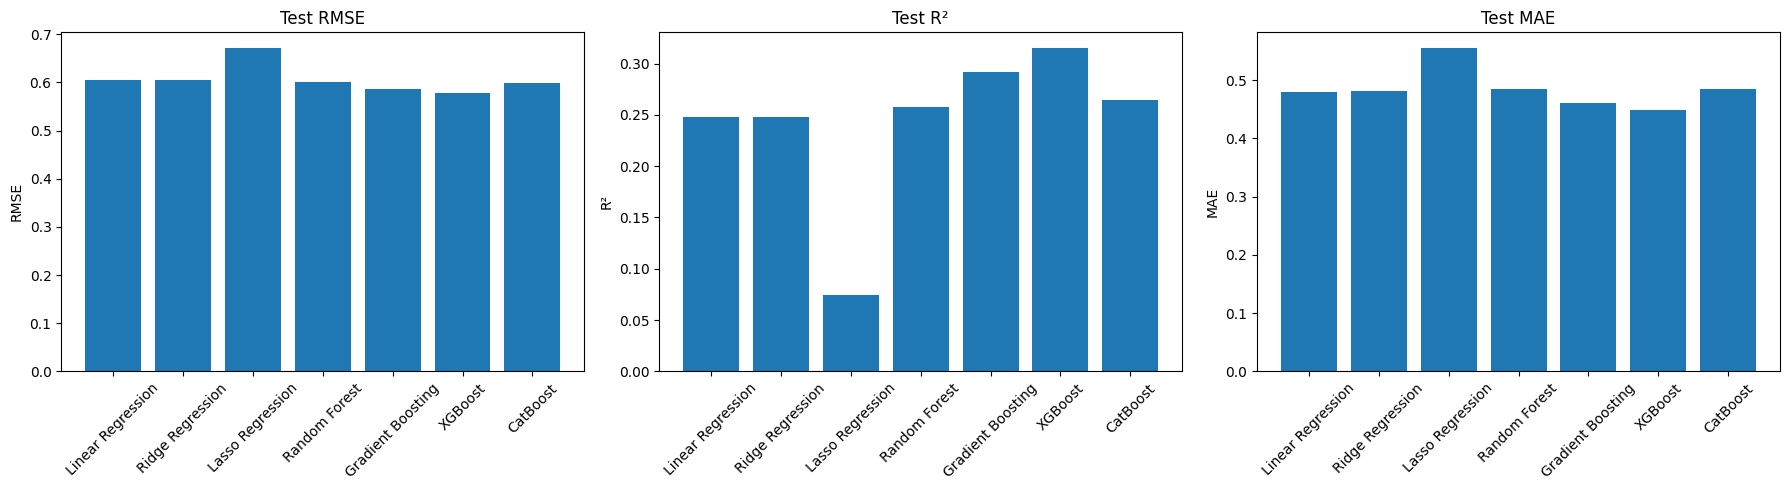

In [53]:
# Инициализация моделей с параметрами
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,      # количество деревьев
        max_depth=3,          # ограничение глубині
        min_samples_split=20, #  минимальное количество сэмплов для разделения
        min_samples_leaf=10,  #  минимальное количество сэмплов в листе
        max_features=0.5,     # Используем только половину признаков
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=50,      #  количество деревьев
        max_depth=3,          #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        colsample_bytree=0.8, #  сабсэмплинг по признакам
        reg_alpha=0.1,        # L1 регуляризация
        reg_lambda=1.0,       # L2 регуляризация
        random_state=42,
        eval_metric='rmse'
    ),
    'CatBoost': cb.CatBoostRegressor(
        iterations=50,        #  количество итераций
        depth=3,              #  ограничили глубину
        learning_rate=0.05,   #  уменьшили скорость обучения
        subsample=0.8,        #  сабсэмплинг
        l2_leaf_reg=3.0,      #  L2 регуляризация
        random_state=42,
        verbose=False
    )
}
# Обучение и оценка базовых моделей
baseline_results = []
baseline_predictions = {}

for name, model in models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    baseline_results.append(results)
    baseline_predictions[name] = y_pred

# Результаты в DataFrame
baseline_df = pd.DataFrame(baseline_results)
print("\n=== РЕЗУЛЬТАТЫ БАЗОВЫХ МОДЕЛЕЙ ===")
print(baseline_df.round(4))

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
axes[0].bar(baseline_df['Model'], baseline_df['Test_RMSE'])
axes[0].set_title('Test RMSE')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# R²
axes[1].bar(baseline_df['Model'], baseline_df['Test_R2'])
axes[1].set_title('Test R²')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)

# MAE
axes[2].bar(baseline_df['Model'], baseline_df['Test_MAE'])
axes[2].set_title('Test MAE')
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Подбор гиперпараметров с использованием Optuna

In [57]:
def optimize_random_forest(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Random Forest"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 4, 7),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'max_features': trial.suggest_float('max_features', 0.4, 0.8),
            'max_samples': trial.suggest_float('max_samples', 0.7, 0.9),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Random Forest - Лучший RMSE: {study.best_value:.4f}")
    print(f"Random Forest - Лучшие параметры: {study.best_params}")

    return study.best_params

In [58]:
def optimize_gradient_boosting(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для Gradient Boosting"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'min_samples_split': trial.suggest_int('min_samples_split', 10, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'max_features': trial.suggest_float('max_features', 0.5, 0.9),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Gradient Boosting - Лучший RMSE: {study.best_value:.4f}")
    print(f"Gradient Boosting - Лучшие параметры: {study.best_params}")

    return study.best_params

In [59]:
def optimize_xgboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для XGBoost"""

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
            'random_state': 42,
            'eval_metric': 'rmse'
        }

        model = xgb.XGBRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"XGBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"XGBoost - Лучшие параметры: {study.best_params}")

    return study.best_params

In [60]:
def optimize_catboost(X_train, y_train, n_trials=50):
    """Оптимизация гиперпараметров для CatBoost"""

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'depth': trial.suggest_int('depth', 4, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.9),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 15.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
            'random_state': 42,
            'verbose': False
        }

        model = cb.CatBoostRegressor(**params)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                   scoring='neg_mean_squared_error')
        return np.sqrt(-cv_scores.mean())

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"CatBoost - Лучший RMSE: {study.best_value:.4f}")
    print(f"CatBoost - Лучшие параметры: {study.best_params}")

    return study.best_params

In [61]:
print("=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===")

rf_best_params = optimize_random_forest(X_train, y_train, n_trials=30)
gb_best_params = optimize_gradient_boosting(X_train, y_train, n_trials=30)
xgb_best_params = optimize_xgboost(X_train, y_train, n_trials=30)
catb_best_params = optimize_catboost(X_train, y_train, n_trials=30)

[I 2025-06-17 17:05:26,015] A new study created in memory with name: no-name-84d56a56-6ece-4249-8586-79c3b674cf5b


=== ПОДБОР ГИПЕРПАРАМЕТРОВ ===


[I 2025-06-17 17:05:28,939] Trial 0 finished with value: 0.578253400207876 and parameters: {'n_estimators': 245, 'max_depth': 6, 'min_samples_split': 35, 'min_samples_leaf': 18, 'max_features': 0.4625252214958997, 'max_samples': 0.8540376901811123}. Best is trial 0 with value: 0.578253400207876.
[I 2025-06-17 17:05:32,373] Trial 1 finished with value: 0.5793571513676528 and parameters: {'n_estimators': 248, 'max_depth': 6, 'min_samples_split': 39, 'min_samples_leaf': 16, 'max_features': 0.7367550759460852, 'max_samples': 0.7247724538148408}. Best is trial 0 with value: 0.578253400207876.
[I 2025-06-17 17:05:34,368] Trial 2 finished with value: 0.5693125682835762 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 0.7664133087020117, 'max_samples': 0.715289743588105}. Best is trial 2 with value: 0.5693125682835762.
[I 2025-06-17 17:05:36,438] Trial 3 finished with value: 0.576474195033018 and parameters: {'n_estimators':

Random Forest - Лучший RMSE: 0.5512
Random Forest - Лучшие параметры: {'n_estimators': 162, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 0.7138876362916982, 'max_samples': 0.8008929603382067}


[I 2025-06-17 17:06:49,460] Trial 0 finished with value: 0.5506410066740566 and parameters: {'n_estimators': 456, 'max_depth': 4, 'learning_rate': 0.08599546450943375, 'subsample': 0.7577158991302257, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 0.68099776452224}. Best is trial 0 with value: 0.5506410066740566.
[I 2025-06-17 17:07:00,560] Trial 1 finished with value: 0.5566980651156669 and parameters: {'n_estimators': 464, 'max_depth': 6, 'learning_rate': 0.09951649347812669, 'subsample': 0.8409396080912155, 'min_samples_split': 46, 'min_samples_leaf': 12, 'max_features': 0.8562500110230491}. Best is trial 0 with value: 0.5506410066740566.
[I 2025-06-17 17:07:06,639] Trial 2 finished with value: 0.5360517221851382 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.03369122711280816, 'subsample': 0.7523424700103751, 'min_samples_split': 37, 'min_samples_leaf': 17, 'max_features': 0.866347936660901}. Best is trial 2 with value: 0.5360517221851382

Gradient Boosting - Лучший RMSE: 0.5334
Gradient Boosting - Лучшие параметры: {'n_estimators': 478, 'max_depth': 5, 'learning_rate': 0.011805682554156496, 'subsample': 0.7907685731629186, 'min_samples_split': 38, 'min_samples_leaf': 9, 'max_features': 0.8352472840465132}


[I 2025-06-17 17:09:53,229] Trial 0 finished with value: 0.5436364688930216 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.11300593154911641, 'subsample': 0.710186744630907, 'colsample_bytree': 0.6569602015944388, 'colsample_bylevel': 0.6730602904870332, 'reg_alpha': 0.9156285799218109, 'reg_lambda': 2.3486572223083906, 'min_child_weight': 7}. Best is trial 0 with value: 0.5436364688930216.
[I 2025-06-17 17:09:54,759] Trial 1 finished with value: 0.5350051735328937 and parameters: {'n_estimators': 313, 'max_depth': 4, 'learning_rate': 0.059785318605820106, 'subsample': 0.8401009148090117, 'colsample_bytree': 0.772273315129469, 'colsample_bylevel': 0.6865892918638993, 'reg_alpha': 1.8266273304258864, 'reg_lambda': 2.2614335718935896, 'min_child_weight': 3}. Best is trial 1 with value: 0.5350051735328937.
[I 2025-06-17 17:09:56,280] Trial 2 finished with value: 0.5363364654644598 and parameters: {'n_estimators': 257, 'max_depth': 3, 'learning_rate': 0.1184610836

XGBoost - Лучший RMSE: 0.5304
XGBoost - Лучшие параметры: {'n_estimators': 426, 'max_depth': 3, 'learning_rate': 0.051994877359794425, 'subsample': 0.7358144690926964, 'colsample_bytree': 0.8597860463567628, 'colsample_bylevel': 0.7542069074704427, 'reg_alpha': 1.4405810594339474, 'reg_lambda': 3.9609203745209505, 'min_child_weight': 10}


[I 2025-06-17 17:10:33,837] Trial 0 finished with value: 0.5411662967677663 and parameters: {'iterations': 448, 'depth': 4, 'learning_rate': 0.04335410299139191, 'subsample': 0.8130935320070092, 'colsample_bylevel': 0.8614581104512652, 'l2_leaf_reg': 14.249554138523305, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.5411662967677663.
[I 2025-06-17 17:10:34,558] Trial 1 finished with value: 0.5450176475066256 and parameters: {'iterations': 195, 'depth': 4, 'learning_rate': 0.07590775351954208, 'subsample': 0.85723131426987, 'colsample_bylevel': 0.812004284457378, 'l2_leaf_reg': 7.814889979302907, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.5411662967677663.
[I 2025-06-17 17:10:35,429] Trial 2 finished with value: 0.5355968955976592 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.0711028894443147, 'subsample': 0.7209527827907622, 'colsample_bylevel': 0.7140543560432987, 'l2_leaf_reg': 7.819295455289648, 'min_data_in_leaf': 14}. Best is trial 2 with va

CatBoost - Лучший RMSE: 0.5338
CatBoost - Лучшие параметры: {'iterations': 480, 'depth': 5, 'learning_rate': 0.05523055240447044, 'subsample': 0.8106288130734509, 'colsample_bylevel': 0.6289817899406005, 'l2_leaf_reg': 3.1985264689973967, 'min_data_in_leaf': 15}


Оптимизированные модели

In [62]:
optimized_models = {
    'Random Forest (Optimized)': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting (Optimized)': GradientBoostingRegressor(**gb_best_params),
    'XGBoost (Optimized)': xgb.XGBRegressor(**xgb_best_params),
    'CatBoost (Optimized)': cb.CatBoostRegressor(**catb_best_params)
}

In [63]:
optimized_results = []
optimized_predictions = {}

for name, model in optimized_models.items():
    print(f"Обучение {name}...")
    results, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    optimized_results.append(results)
    optimized_predictions[name] = y_pred

# Результаты оптимизированных моделей
optimized_df = pd.DataFrame(optimized_results)
print(optimized_df.round(4))

# Сравнение с базовыми моделями
comparison_data = []

base_models_subset = baseline_df[baseline_df['Model'].isin([
    'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost'
])]

for _, base_row in base_models_subset.iterrows():
    model_name = base_row['Model']
    opt_row = optimized_df[optimized_df['Model'] == f"{model_name} (Optimized)"].iloc[0]

    comparison_data.append({
        'Model': model_name,
        'Base_Test_RMSE': base_row['Test_RMSE'],
        'Opt_Test_RMSE': opt_row['Test_RMSE'],
        'Improvement': base_row['Test_RMSE'] - opt_row['Test_RMSE'],
        'Base_Test_R2': base_row['Test_R2'],
        'Opt_Test_R2': opt_row['Test_R2']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))


Обучение Random Forest (Optimized)...
Обучение Gradient Boosting (Optimized)...
Обучение XGBoost (Optimized)...
Обучение CatBoost (Optimized)...
0:	learn: 0.7041884	total: 748us	remaining: 358ms
1:	learn: 0.6968496	total: 1.48ms	remaining: 353ms
2:	learn: 0.6876704	total: 2.52ms	remaining: 400ms
3:	learn: 0.6785839	total: 3.22ms	remaining: 384ms
4:	learn: 0.6709169	total: 4.19ms	remaining: 398ms
5:	learn: 0.6641544	total: 4.89ms	remaining: 386ms
6:	learn: 0.6566608	total: 5.7ms	remaining: 385ms
7:	learn: 0.6494510	total: 6.43ms	remaining: 379ms
8:	learn: 0.6422431	total: 7.35ms	remaining: 384ms
9:	learn: 0.6375794	total: 8.08ms	remaining: 380ms
10:	learn: 0.6317340	total: 8.95ms	remaining: 381ms
11:	learn: 0.6248209	total: 9.64ms	remaining: 376ms
12:	learn: 0.6202835	total: 10.6ms	remaining: 382ms
13:	learn: 0.6149853	total: 11.4ms	remaining: 379ms
14:	learn: 0.6094712	total: 12ms	remaining: 373ms
15:	learn: 0.6049738	total: 12.7ms	remaining: 369ms
16:	learn: 0.6007384	total: 13.6ms	re

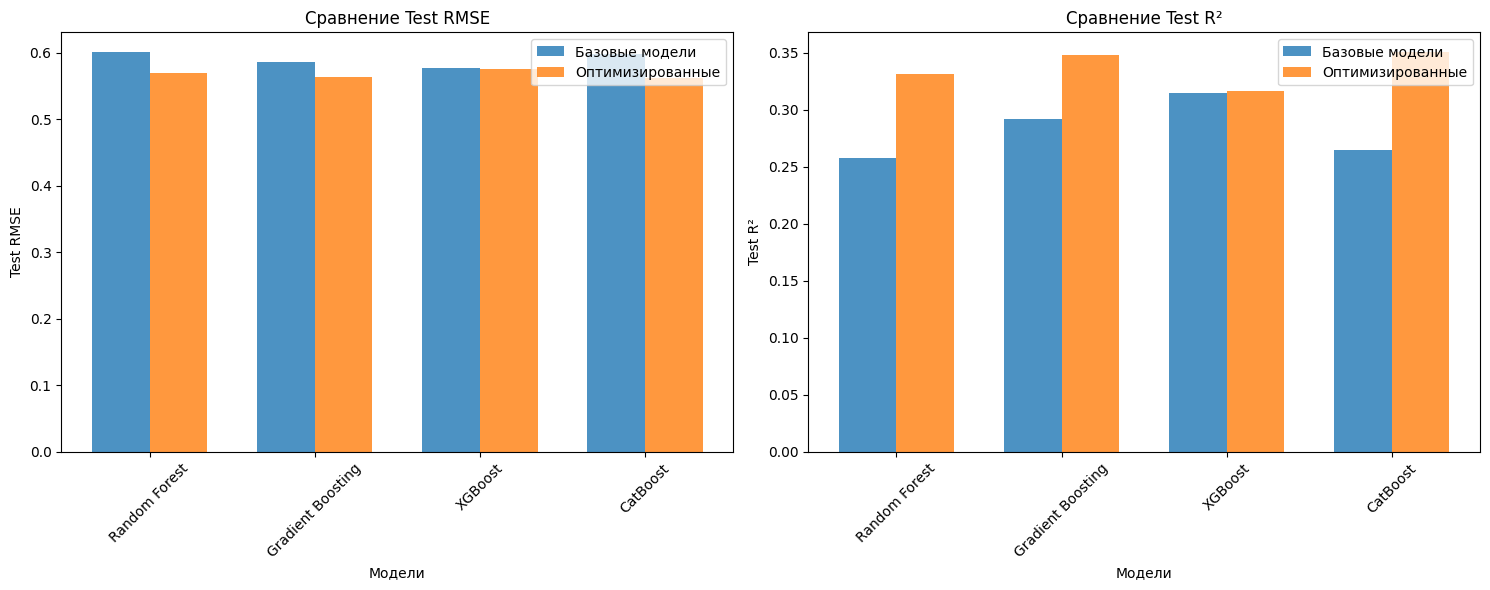

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Base_Test_RMSE'], width,
           label='Базовые модели', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['Opt_Test_RMSE'], width,
           label='Оптимизированные', alpha=0.8)
axes[0].set_xlabel('Модели')
axes[0].set_ylabel('Test RMSE')
axes[0].set_title('Сравнение Test RMSE')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[0].legend()

# R2
axes[1].bar(x_pos - width/2, comparison_df['Base_Test_R2'], width,
           label='Базовые модели', alpha=0.8)
axes[1].bar(x_pos + width/2, comparison_df['Opt_Test_R2'], width,
           label='Оптимизированные', alpha=0.8)
axes[1].set_xlabel('Модели')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Сравнение Test R²')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()